In [12]:
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras as ks
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
import cv2

seed = 1234
np.random.seed(seed)
tf.random.set_seed(seed)


In [2]:
# define the parent folder containing the directories with images
parent_folder = "captchas/images"

# define the list of valid image extensions
valid_extensions = [".jpg", ".jpeg", ".png", ".gif"]

# create an empty list to store the image paths and labels
data = []

# iterate through each directory in the parent folder
for dir_name in os.listdir(parent_folder):
    if not os.path.isdir(os.path.join(parent_folder, dir_name)):
        continue

    # iterate through each file in the directory
    for file_name in os.listdir(os.path.join(parent_folder, dir_name)):
        # check if the file extension is valid
        _, ext = os.path.splitext(file_name)
        if ext.lower() not in valid_extensions:
            continue

        # create a dictionary containing the image path and its label
        img_path = os.path.join(parent_folder, dir_name, file_name)
        label = dir_name
        data.append({"img_path": img_path, "label": label})

# create a dataframe from the list of dictionaries
dataset = pd.DataFrame(data)

# Shuffle the dataset
dataset = dataset.sample(frac=1.).reset_index(drop=True)


# preview the first few rows of the dataframe
print(dataset.head())

                                    img_path      label
0          captchas/images/Bus/Bus (739).png        Bus
1  captchas/images/Hydrant/Hydrant (192).png    Hydrant
2  captchas/images/Crosswalk/Cross (998).png  Crosswalk
3  captchas/images/Bicycle/Bicycle (217).png    Bicycle
4       captchas/images/Other/Other (92).png      Other


(120, 120, 3)
(100, 100, 3)
(120, 120, 3)
(100, 100, 3)
(120, 120, 3)
(100, 100, 3)
(120, 120, 3)
(120, 120, 3)
(120, 120, 3)


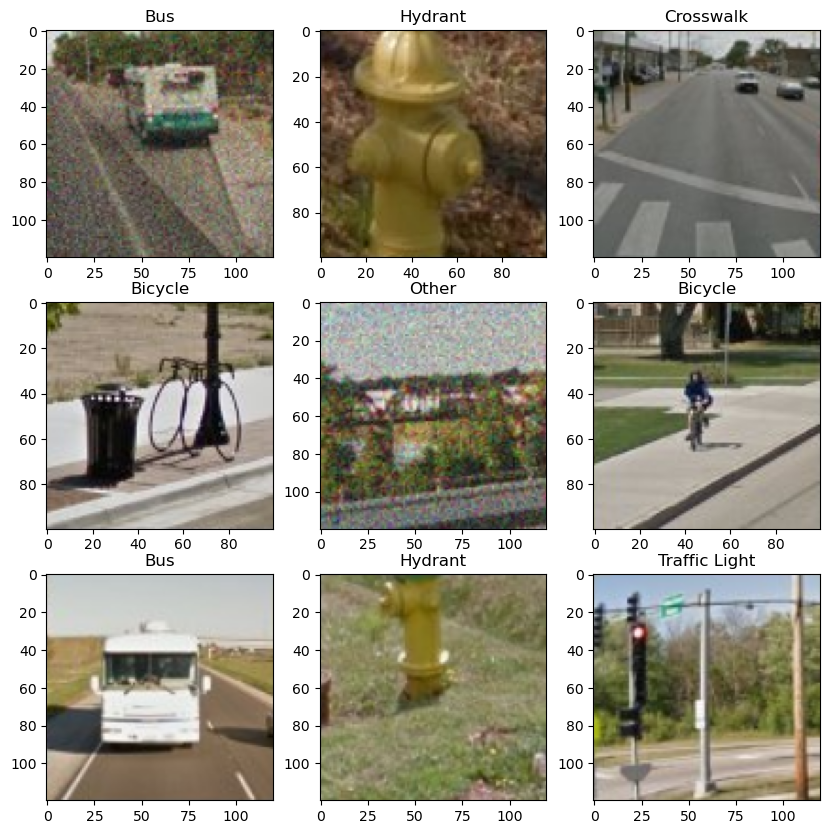

In [3]:
# Sow a sample of the images and their labels
fig, ax = plt.subplots(3, 3, figsize=(10, 10))
for i in range(3):
    for j in range(3):
        # read the image
        img = cv2.imread(dataset.iloc[i * 3 + j]["img_path"])
        print(img.shape)
        # convert to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # plot the image
        ax[i, j].imshow(img)
        # set the title
        ax[i, j].set_title(dataset.iloc[i * 3 + j]["label"])
plt.show()

In [4]:
train, test = train_test_split(dataset, test_size=0.15, random_state=seed)

train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

print("Number of training samples: ", len(train))
print("Number of validation samples: ", len(test))

Number of training samples:  9970
Number of validation samples:  1760


In [5]:
class_names = dataset["label"].unique()

def encode_label(label):
    return np.argmax(label == class_names)

def decode_label(label):
    return class_names[label]


In [6]:
def load_images_and_labels(df):
    """
    Load images and labels from a dictionary of image paths and labels.

    Parameters:
        image_dict (dict): A dictionary containing image paths and labels.

    Returns:
        A tuple containing two numpy arrays:
            - images (np.array): An array containing the loaded images in grayscale.
            - labels (np.array): An array containing the labels for each image.
    """
    # create an empty list to store the loaded images and labels
    images = []
    labels = []

    for index, row in df.iterrows():
        # load the image in grayscale
        img = cv2.imread(row['img_path'], cv2.IMREAD_COLOR)

        # resize the image to 120x120 with 3 color channels
        img = cv2.resize(img, (120, 120))

        # append the image and label to the lists
        images.append(img)
        labels.append(encode_label(row['label']))


    # convert the lists to numpy arrays
    images = np.array(images)
    labels = np.array(labels)

    # return the numpy arrays
    return images, labels

In [7]:
X_train, y_train = load_images_and_labels(train)
X_test, y_test = load_images_and_labels(test)

print("Number of training images: ", X_train.shape)
print("Number of training labels: ", y_train.shape)

print("Number of validation images: ", X_test.shape)
print("Number of validation labels: ", y_test.shape)

Number of training images:  (9970, 120, 120, 3)
Number of training labels:  (9970,)
Number of validation images:  (1760, 120, 120, 3)
Number of validation labels:  (1760,)


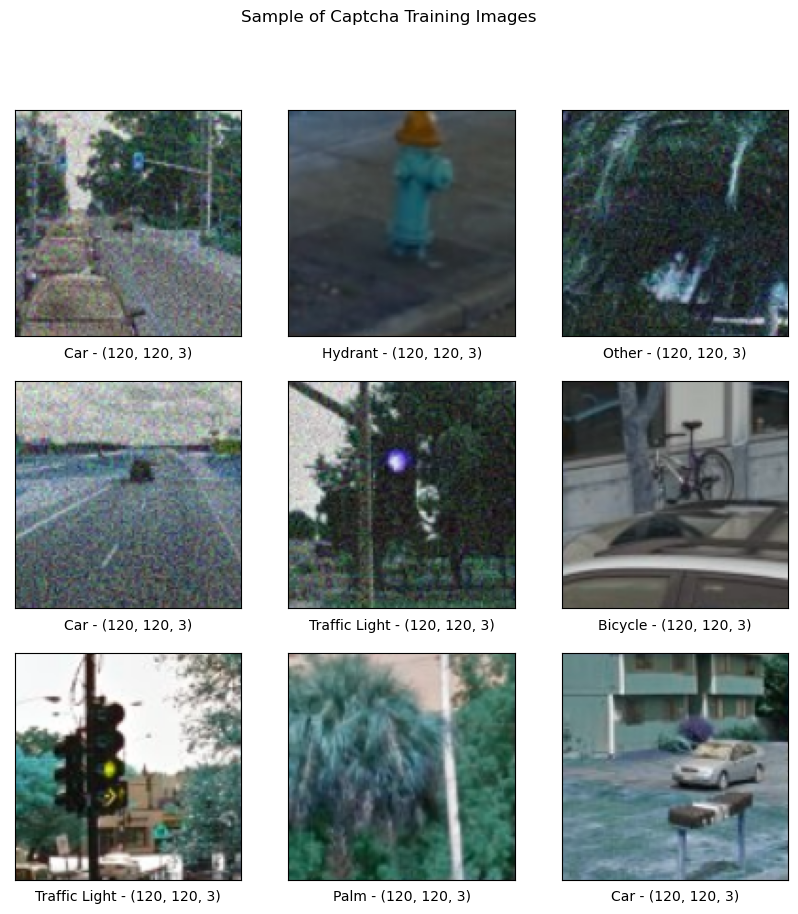

In [8]:
# Show a sample of training images and labels
plt.figure(figsize=(10, 10))

num_samples = 9
sqr = int(np.sqrt(num_samples))
indices = np.random.choice(np.arange(len(X_train)), size=num_samples, replace=False)

sample_images = X_train[indices]
sample_labels = y_train[indices]

for i in range(num_samples):
    plt.subplot(sqr, sqr, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(sample_images[i], cmap=plt.cm.binary)
    plt.xlabel(f"{decode_label(sample_labels[i])} - {sample_images[i].shape}")
plt.suptitle('Sample of Captcha Training Images')
plt.show()

In [20]:
model = ks.Sequential()
model.add(ks.layers.Flatten(input_shape=(120, 120, 3)))
model.add(ks.layers.BatchNormalization())
neurons = [256, 128, 64, 32]

for neuron in neurons:
    model.add(ks.layers.Dense(units=neuron, activation='relu'))

model.add(ks.layers.Dense(units=len(class_names), activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_7 (Flatten)         (None, 43200)             0         
                                                                 
 batch_normalization_1 (Batc  (None, 43200)            172800    
 hNormalization)                                                 
                                                                 
 dense_7 (Dense)             (None, 256)               11059456  
                                                                 
 dense_8 (Dense)             (None, 128)               32896     
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                      

In [21]:
history = model.fit(X_train, y_train,
                    batch_size=100,
                    epochs=20,
                    verbose=1,
                    validation_data=(X_test, y_test))

Epoch 1/20
100/100 [==============================] - 6s 55ms/step - loss: 3.1104 - accuracy: 0.2491 - val_loss: 2.4649 - val_accuracy: 0.2778
Epoch 2/20
100/100 [==============================] - 6s 56ms/step - loss: 2.1841 - accuracy: 0.3422 - val_loss: 2.1625 - val_accuracy: 0.3426
Epoch 3/20
100/100 [==============================] - 6s 58ms/step - loss: 2.0128 - accuracy: 0.3684 - val_loss: 2.1273 - val_accuracy: 0.3574
Epoch 4/20
100/100 [==============================] - 6s 59ms/step - loss: 1.9054 - accuracy: 0.3902 - val_loss: 2.0166 - val_accuracy: 0.3631
Epoch 5/20
100/100 [==============================] - 6s 57ms/step - loss: 1.7857 - accuracy: 0.4120 - val_loss: 1.9841 - val_accuracy: 0.3795
Epoch 6/20
100/100 [==============================] - 6s 56ms/step - loss: 1.7084 - accuracy: 0.4204 - val_loss: 1.9931 - val_accuracy: 0.3795
Epoch 7/20
100/100 [==============================] - 6s 56ms/step - loss: 1.6206 - accuracy: 0.4466 - val_loss: 1.9355 - val_accuracy: 0.3824

1/1 [==============================] - 0s 19ms/step


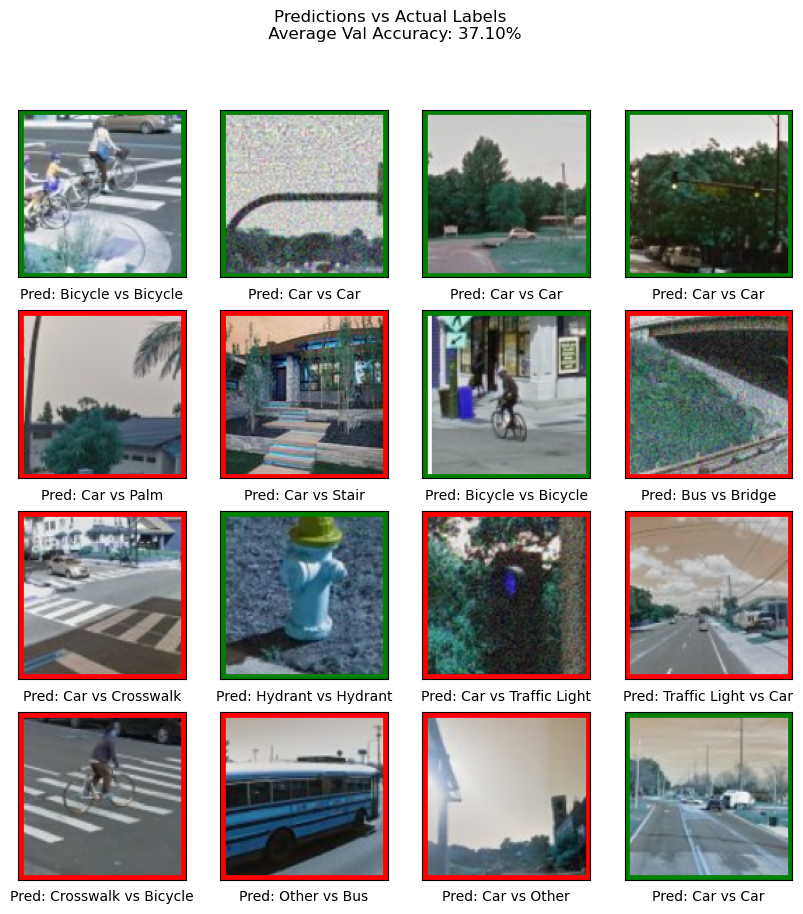

In [34]:
# Compare the predictions with the actual labels
plt.figure(figsize=(10, 10))

num_samples = 16
sqr = int(np.sqrt(num_samples))
indices = np.random.choice(np.arange(len(X_test)), size=num_samples, replace=False)

sample_images = X_test[indices]
sample_labels = y_test[indices]



for i in range(num_samples):
    plt.subplot(sqr, sqr, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(sample_images[i], cmap=plt.cm.binary)
    pred = model.predict(sample_images[i:i+1])


    pred_label = decode_label(np.argmax(pred))
    true_label = decode_label(sample_labels[i])

    plt.xlabel(f"Pred: {pred_label} vs {true_label}")

    

     # Draw a green border around the image if the prediction is correct and a red border if it is incorrect
    if pred_label == true_label:
        plt.gca().add_patch(plt.Rectangle((0, 0), 120, 120, fill=False, edgecolor='green', linewidth=7))
    else:
        plt.gca().add_patch(plt.Rectangle((0, 0), 120, 120, fill=False, edgecolor='red', linewidth=7))
average_accuracy = np.mean(history.history['val_accuracy'])
plt.suptitle(f'Predictions vs Actual Labels \n Average Val Accuracy: {average_accuracy*100:.2f}%')
plt.show()

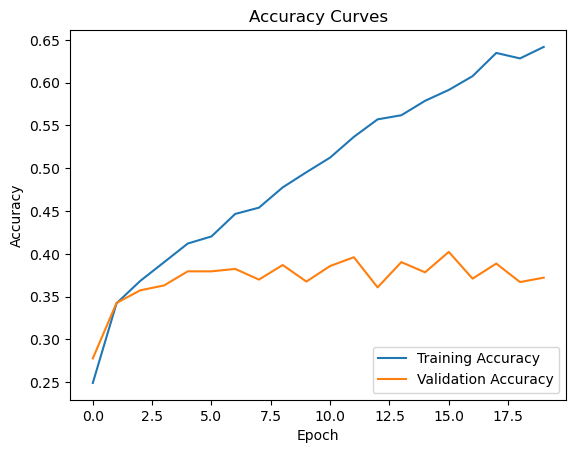

In [32]:
# Plot the accuracy curves for training and validation
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()


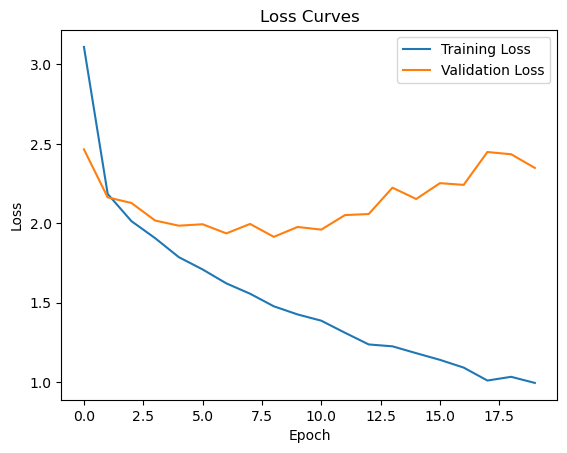

In [35]:
# Plot the loss curves for training and validation
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

